In [266]:
import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn

import optax
import tensorflow as tf
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import tensorflow_probability.substrates.jax as tfp

## The Dataset

(-2.0, 2.0)

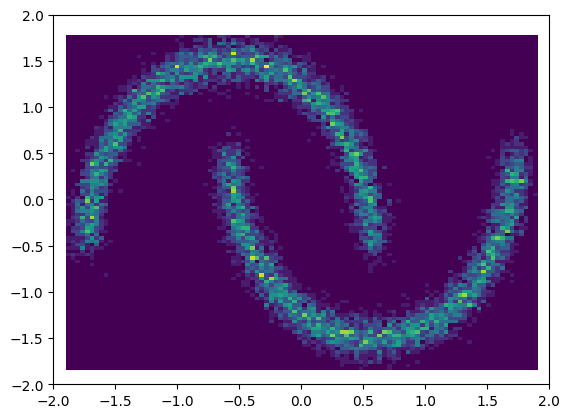

In [267]:
from sklearn import datasets, preprocessing

n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [268]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 64
    out_dim: int = 2
    n_layers: int = 6

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [258]:
from einops import rearrange

class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 32
    num_out: int = 2

    def setup(self):
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=self.num_out)

    def __call__(self, x, z_rng):

        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar))).sample(seed=z_rng)

        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

@jax.vmap
def kl_divergence(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior
    """
    prior_latent = tfp.distributions.Normal(loc=0., scale=1.)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar)))  # Variational latent distrib.
    
    return tfp.distributions.kl_divergence(q_latent, prior_latent)

@jax.vmap
def mse_loss(pred, true, scale=0.1):
    """ Gaussian MSE
    """
    return (pred - true) ** 2 / scale ** 2

In [259]:
vae = VAE()
key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16], z_key)

In [260]:
def loss_fn(params, x_batch, z_rng):
    recon_x, mean, logvar = vae.apply(params, x_batch, z_rng)

    reco_loss = mse_loss(recon_x, x_batch).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = reco_loss + kld_loss
    return loss

print(loss_fn(params, x[:16], key))

111.11076


In [261]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [262]:
n_steps = 1000
n_batch = 128

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [01:32<00:00, 10.80it/s, val=1.5540501]


In [263]:
@jax.jit
def eval(params, z):
    def eval_model(vae):
        return vae.decoder(z)
    return nn.apply(eval_model, vae)(params)

In [264]:
z = jax.random.normal(key, shape=(10000, 32))
x_sample = eval(params, z)

(-2.0, 2.0)

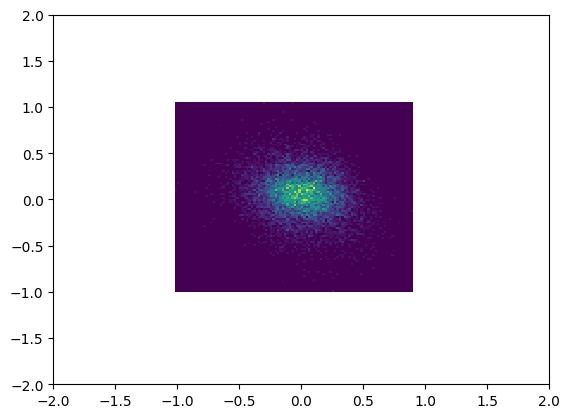

In [265]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100);
plt.xlim(-2 ,2)
plt.ylim(-2, 2)